<a href="https://colab.research.google.com/github/Ryuta2329/Msc-Math-Applied/blob/main/Series%20Temporales/SOI_Recruitment_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
library(astsa, quietly = TRUE)
library(ggfortify, quietly = TRUE)
library(tsibble, quietly = TRUE)
library(fable, quietly = TRUE)
library(fabletools, quietly = TRUE)
library(dynlm, quietly = TRUE)

In [49]:
soi_df <- as_tsibble(cbind(soi, rec))

# El Niño y la poblacion de peces.

Estos datos corresponden a valores mensuales de series ambientales llamada _Índice de Oscilación del Sur_ (SOI, por sus siglas en ingles) y el reclutamiento asociado (medido como el número de nuevos peces) proporcionados por el Dr. Roy Mendelssohn del grupo de pescadores ambientales del Pacífico. Ambas series son del periodo de 453 meses dentro del intervalo de tiempo de 1950-1987. El SOI mide los cambios en la presión del aire, relacionados a las temperaturas de la superficie del océano en el Océano Pacífico Central. Este se caliente cada 3 a 7 años debido al efecto de El Niño. 

En la serie se pueden observar fácilmente ciclos, detectándose dos tipos básicos de oscilaciones:

* Un ciclo anual obvio (verano-invierno).
* Una frecuencia mas pequeña que parece repetirse cerca de cada 4 años

Este comportamiento peródico es de interés dado que los procesos subyacentes pueden ser regulares y la tasa de _frecuencia_ de oscilación que caracteriza el comportamiento de la serie permitiría identificarlos.

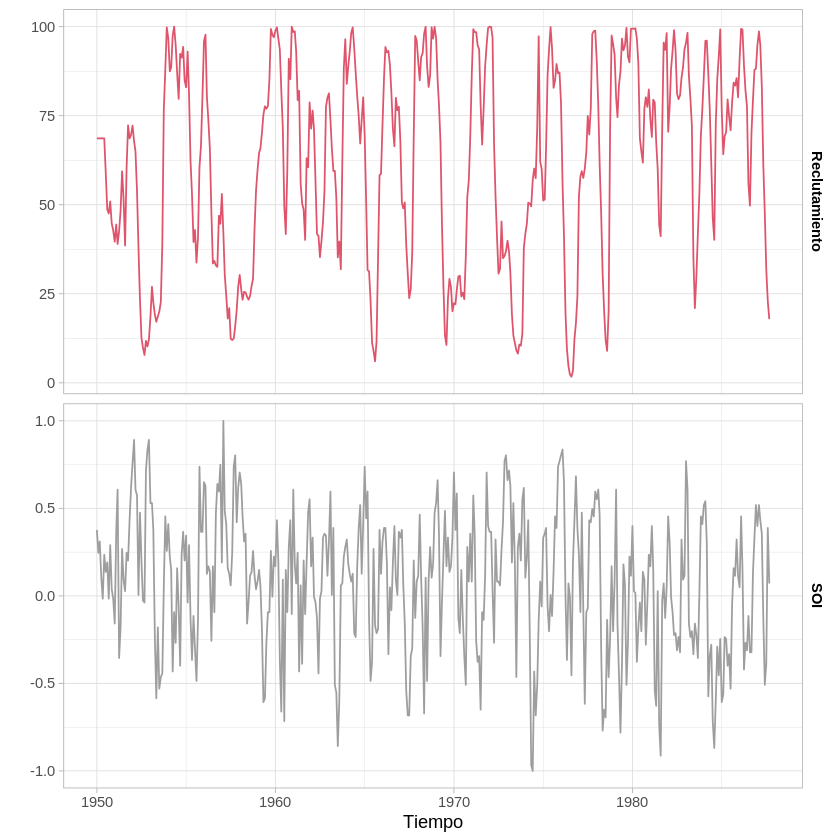

In [72]:
soi_df |>
  ggplot(aes(x=as.Date(index), y=value, colour=key)) +
    geom_line() + 
    scale_colour_manual(values=c(2, 200)) +
    facet_grid(rows=vars(key), 
      labeller=as_labeller(c(`soi`="SOI", `rec`="Reclutamiento")), 
      scales="free") +
    xlab("Tiempo") + ylab("") +
    theme_light() + 
    theme(legend.position="none", 
      strip.background = element_rect(colour="white", fill="white"),
      strip.text.y = element_text(colour="black", face = "bold"))

Las series mostradas muestran un patrón repetitivo, con ciclos más o menos regulares, lo cual podría indicar que el proceso es regular y que la frecuencia de ocislación que caracteriza al patrón podría ayudar a identificar los eventos del Niño.

Ambos ACF exhiben periodicidades correspondientes a la correlación entre valores separados por $12$ unidades. Las observaciones con $12$ meses o un año de diferencia están fuertemente correlacionadas positivamente, al igual que las observaciones en múltiplos como $24, 36, 48, \ldots$ Las observaciones separadas por seis meses están negativamente correlacionadas, lo que muestra que las excursiones positivas tienden a asociarse con excursiones negativas con seis meses de diferencia.

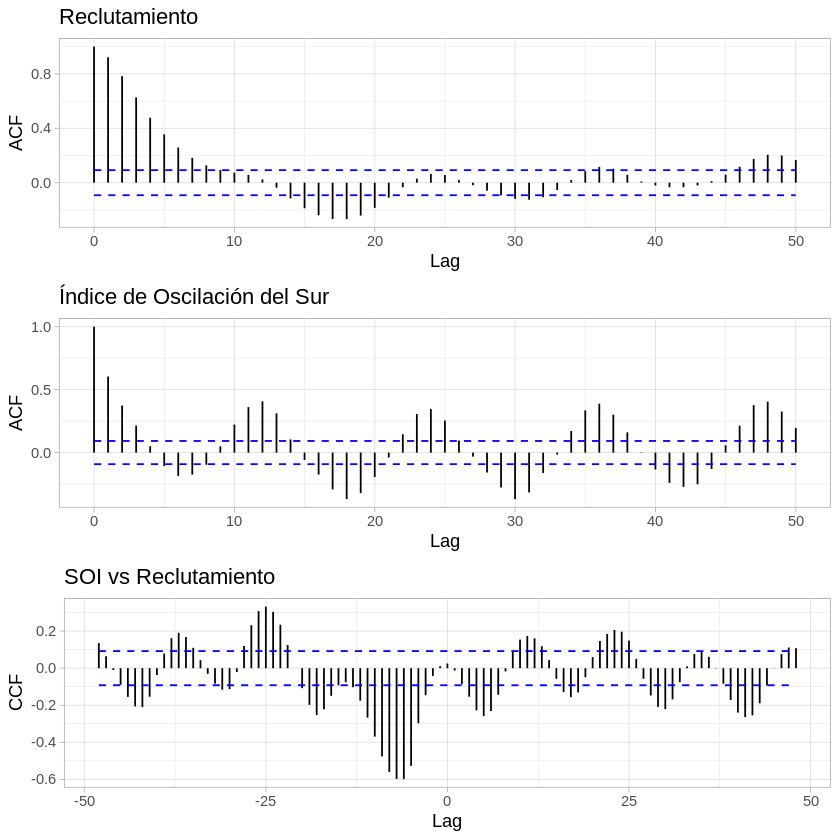

In [114]:
acf_ccf <- soi_df |>
  split(~key) |>
  purrr::map(function(series) {
    series |>
      subset(select=value) |>
      acf(plot=FALSE, lag=50) |>
      autoplot() +
        theme_light() +
        ggtitle(ifelse("soi" %in% series$key, 
          "Índice de Oscilación del Sur",
          "Reclutamiento"))
  })
acf_ccf$ccf_soi_rec <- ccf(
  subset(soi_df, key == "soi", selec="value"), 
  subset(soi_df, key == "rec", selec="value"), 
  48, plot=FALSE) |>
  autoplot() +
    theme_light() + ylab("CCF") +
    ggtitle("SOI vs Reclutamiento")

cowplot::plot_grid(plotlist=acf_ccf, ncol=1)

El CCF de muestra, sin embargo, alguna desviación del componente cíclico de cada serie y hay un pico obvio en $h = −6$. Este resultado implica que el SOI medido en el tiempo $t − 6$ meses está asociado con la serie de Reclutamiento en el tiempo $t$. Podríamos decir que el SOI lidera la serie de Reclutamiento por seis meses. El signo del CCF es negativo, lo que lleva a la conclusión de que las dos series se mueven en direcciones diferentes; es decir, los aumentos en el SOI conducen a disminuciones en el Reclutamiento y viceversa.

## Primer ajuste: regresión con variable retrasada.

Se considera la regresión:

$R_t = \beta_0 + \beta_1S_{t-6} + w_t$

donde $R_t$ es el Reclutamiento en $t$ y $S_{t-6}$ denota la serie SOI seis meses antes. 

In [129]:
#fish <- ts.intersect(rec, soiL6=lag(soi,-6), dframe=TRUE)
#summary(fit1 <- lm(rec~soiL6, data=fish, na.action=NULL)) 
fit2 <- dynlm(rec ~ L(soi,6))

summary(fit2)$sigma

[1] 22.49717